In [1]:
%pip install pandas numpy networkx matplotlib scikit-learn --quiet

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt
import random

In [3]:
cd /content/drive/MyDrive/AnalisiESocialMedia

/content/drive/MyDrive/AnalisiESocialMedia


In [8]:
!git pull

remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 8 (delta 4), reused 8 (delta 4), pack-reused 0 (from 0)
Unpacking objects: 100% (8/8), 68.70 KiB | 475.00 KiB/s, done.
From https://github.com/Alexis2628/progetto_asnm
   8d07348..4c93b40  main       -> origin/main
Updating 8d07348..4c93b40
Fast-forward
 Code/get_follower.py      |    74 +
 Code/main.py              |     4 +-
 Code/threads_interface.py |    48 +-
 data/output.json          | 11759 ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
 4 files changed, 11882 insertions(+), 3 deletions(-)
 create mode 100644 Code/get_follower.py
 create mode 100644 data/output.json


In [ ]:
import json

# Specifica il percorso del file
file_path = "../../../data/output.json"

# Apri e leggi il file JSON
with open(file_path, "r", encoding="utf-8")) as file:
    dati = json.load(file)

# Stampa il contenuto del JSON
print(dati)

# Calcola il numero di utenti
numero_utenti = len(dati)

# Stampa il numero totale di utenti
print(f"Numero totale di utenti: {numero_utenti}")

UnicodeDecodeError: 'charmap' codec can't decode byte 0x9d in position 1537: character maps to <undefined>

In [34]:
df_posts = pd.read_csv("data/post_data.csv")
df_replies = pd.read_csv("data/replies_data.csv")
missing_columns_in_posts = [col for col in df_replies.columns if col not in df_posts.columns]

for col in missing_columns_in_posts:
    df_posts[col] = np.nan

df_combined = pd.concat([df_posts, df_replies], ignore_index=True)
df_combined.columns = [col.lower().replace(" ", "_") for col in df_combined.columns]
df_combined.drop("parent_post_id",axis=1,inplace=True)
# Rimuovi i duplicati basati su user_id
df_combined = df_combined.drop_duplicates(subset='user_id')
df_combined.head()

,post_id,user_id,thread_type,username,profile_picture_url,text_post,like_count,quote_count,caption_text,direct_reply_count,repost_count,following,followed_by,can_reply,reply_control,reshare_count,is_verified
0,3481594135434044840,62926993725,thread,simolude_ai,https://scontent-fco2-1.cdninstagram.com/v/t51...,Aston Martin for you.\n\nFor more pics please ...,7,0.0,Aston Martin for you.\n\nFor more pics please ...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,3482097309088055950,38077850387,thread,vita.consacrata,https://scontent-fco2-1.cdninstagram.com/v/t51...,#genere #intelligenzaartificiale,0,0.0,#genere #intelligenzaartificiale,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,3481793127636829981,1501070805,thread,robymagno65,https://scontent-fco2-1.cdninstagram.com/v/t51...,#intelligenzaartificiale #foto #ottobre #fotog...,2,0.0,#intelligenzaartificiale #foto #ottobre #fotog...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,3438852681247108598,65532133383,thread,news.scienze,https://scontent-fco2-1.cdninstagram.com/v/t51...,La conoscenza della macchina intesa come Intel...,3,0.0,La conoscenza della macchina intesa come Intel...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,3446085903746401933,24736383042,thread,rakesh_yadav_200k,https://scontent-fco2-1.cdninstagram.com/v/t51...,#IntelligenzaArtificiale,21,0.0,#IntelligenzaArtificiale,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN


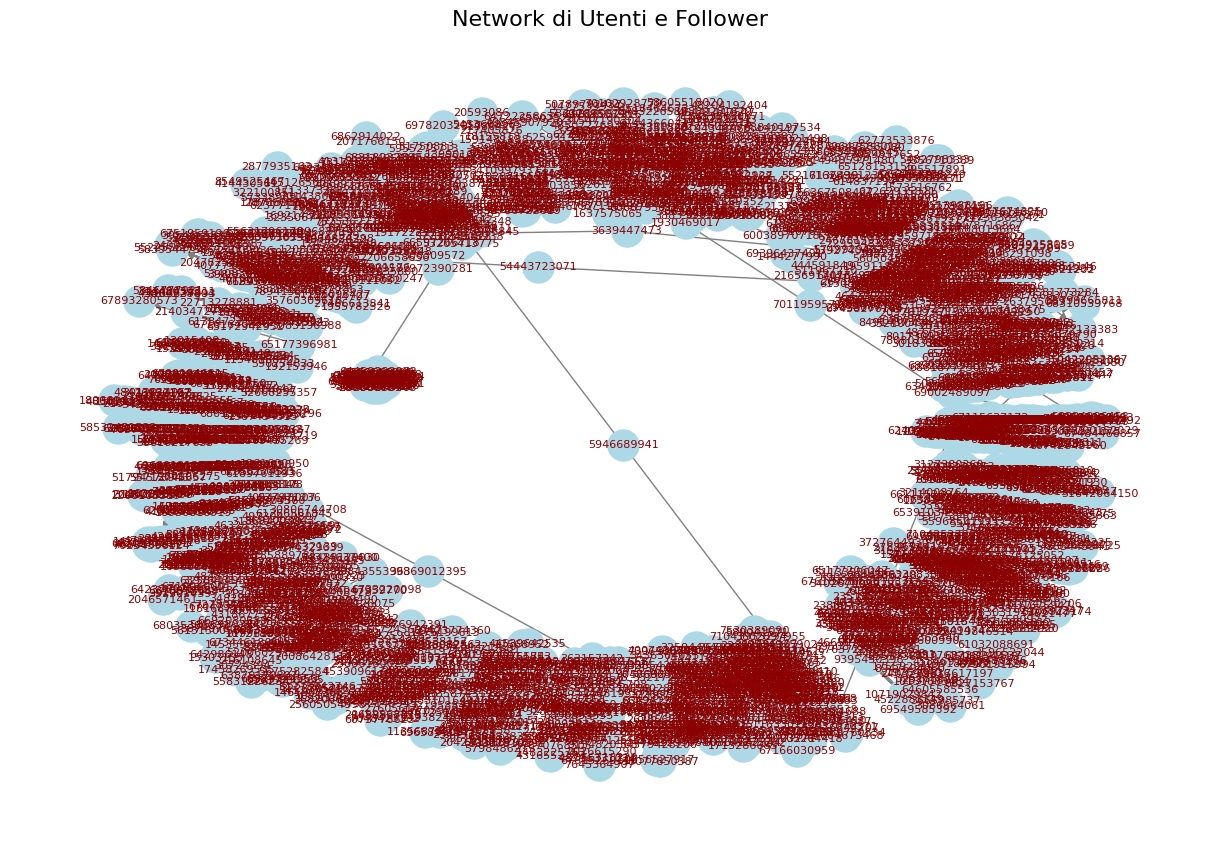

In [36]:
import pandas as pd
import networkx as nx

# Caricamento dei dati dal CSV
df = df_combined

# Creazione del grafo
G = nx.DiGraph()  # Grafo diretto (seguire è un'azione direzionale)

# Mappa dei dati degli utenti dal CSV per un accesso rapido
user_data_map = df.set_index('user_id').to_dict(orient='index')

# Aggiunta di nodi e archi con dati del CSV
for user_id, user_data in dati.items():
    # Aggiungi il nodo dell'utente e i suoi attributi
    user_info = user_data_map.get(user_id, {})
    G.add_node(user_id, **user_info)  # Aggiungi il nodo dell'utente con i dati del CSV

    followers = user_data.get("followers", [])
    for follower in followers:
        follower_username = follower["user_id"]

        # Aggiungi il nodo del follower se non esiste già
        if not G.has_node(follower_username):
            follower_info = user_data_map.get(follower_username, {})
            G.add_node(follower_username, **follower_info)  # Aggiungi il nodo del follower con i dati del CSV

        # Aggiungi l'arco dal follower all'utente
        G.add_edge(follower_username, user_id)

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)  # Layout del grafo
nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=500,
    node_color="lightblue",
    font_size=8,
    font_color="darkred",
    edge_color="gray"
)
plt.title("Network di Utenti e Follower", fontsize=16)
plt.show()


In [37]:
nodi = G.nodes()

# Stampa i nodi
print("Nodi nel grafo:", len(nodi))  # Converte la vista in lista

Nodi nel grafo: 2322


Eseguo l'algoritmo di Girvan-Newman...
Girvan-Newman:  [['60850232106', '531758406', '65391034968', '5547173328', '65070693281', '55968501995', '3756730580', '60628346710', '60966856788', '384363191', '62926993725', '4153445941', '11781456417', '49013546684', '6253539944', '38798206844', '37102490442', '69566543810', '4536264575', '42554616', '11194920225'], ['10027598301', '262856836', '56714285656', '3156028036', '55178050501', '5701199225', '38077850387', '51958843096', '5676816145', '9047692314', '7355542106', '8362525031', '50656527917', '5520169129', '64379260940', '62233317658', '54579428206', '36095397789', '50139636118', '6649417310', '34158564957'], ['5605045968', '3519965980', '33498315874', '1457429221', '3098195771', '1543214540', '1959118787', '5672499286', '4513988196', '1816863531', '33274428172', '6150800787', '1795971330', '1027867451', '39568222', '563838818', '1501070805', '6053379558', '2671484253', '1788931156', '5342759779'], ['64199426995', '65242802457', '53982

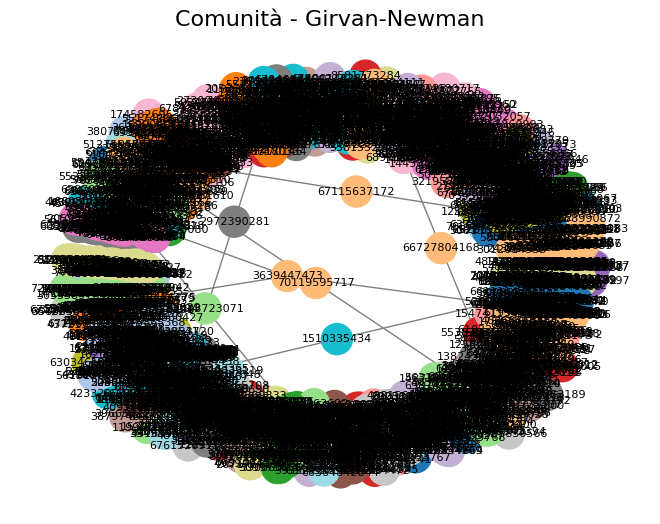

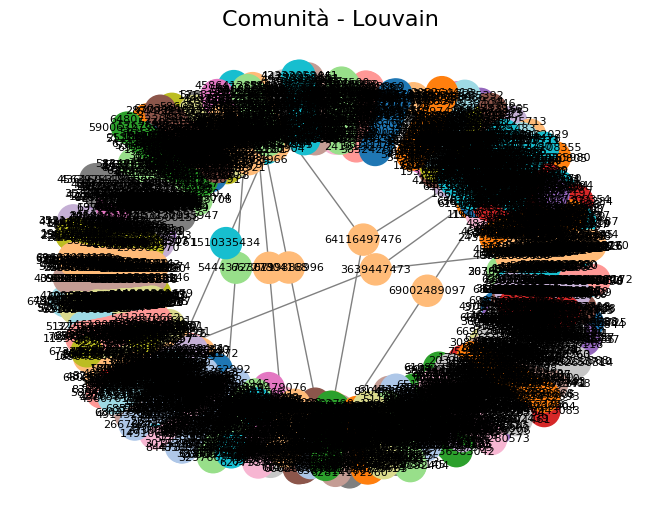

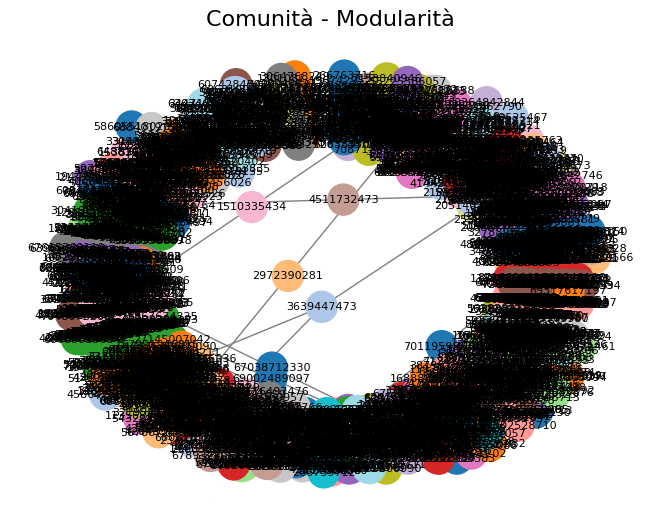

In [38]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms.community import girvan_newman
import community as community_louvain  # Modulo Louvain
from networkx.algorithms.community.quality import modularity

# Funzione per visualizzare le comunità
def draw_communities(G, communities, title):
    pos = nx.spring_layout(G)  # Layout del grafo
    colors = [plt.cm.tab20.colors[i % 20] for i in range(len(communities))]
    node_colors = {}
    for i, community in enumerate(communities):
        for node in community:
            node_colors[node] = colors[i]
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_size=500,
        node_color=[node_colors[node] for node in G.nodes],
        font_size=8,
        font_color="black",
        edge_color="gray"
    )
    plt.title(title, fontsize=16)
    plt.show()

# Algoritmo di Girvan-Newman
def girvan_newman_communities(G):
    comp = girvan_newman(G)
    first_level_communities = next(comp)
    return [list(c) for c in first_level_communities]

# Algoritmo di Louvain
def louvain_communities(G):
    # Convertiamo il grafo diretto in grafo non diretto
    G_undirected = G.to_undirected()
    partition = community_louvain.best_partition(G_undirected)
    communities = {}
    for node, community in partition.items():
        communities.setdefault(community, []).append(node)
    return list(communities.values())

# Algoritmo di modularità
def modularity_communities(G):
    from networkx.algorithms.community import greedy_modularity_communities
    return [list(c) for c in greedy_modularity_communities(G)]

# Esecuzione degli algoritmi
print("Eseguo l'algoritmo di Girvan-Newman...")
gn_communities = girvan_newman_communities(G)
print("Girvan-Newman: ", gn_communities)
print(len(gn_communities))

print("Eseguo l'algoritmo di Louvain...")
louvain_communities_result = louvain_communities(G)
print("Louvain: ", louvain_communities_result)
print(len(louvain_communities_result))


print("Eseguo l'algoritmo di modularità...")
modularity_communities_result = modularity_communities(G)
print("Modularità: ", modularity_communities_result)
print(len(modularity_communities_result))


# Visualizzazione delle comunità
draw_communities(G, gn_communities, "Comunità - Girvan-Newman")
draw_communities(G, louvain_communities_result, "Comunità - Louvain")
draw_communities(G, modularity_communities_result, "Comunità - Modularità")


In [48]:
import nltk
nltk.download('all')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_percep

True

In [49]:
import nltk
print(nltk.data.path)


['/root/nltk_data', '/usr/nltk_data', '/usr/share/nltk_data', '/usr/lib/nltk_data', '/usr/share/nltk_data', '/usr/local/share/nltk_data', '/usr/lib/nltk_data', '/usr/local/lib/nltk_data', '/content/nltk_data']


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [50]:
nltk.download('punkt')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [55]:
!pip install spacy
!python -m spacy download en_core_web_sm


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 47.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [56]:
import spacy
nlp = spacy.load('en_core_web_sm')

def preprocess_text(text):
    # Tokenizza il testo con spacy
    doc = nlp(text.lower())  # Converte in minuscolo
    tokens = [token.text for token in doc if token.is_alpha and not token.is_stop]
    return tokens


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [57]:
import nltk
nltk.download('punkt')  # Aggiungi questa riga per scaricare la risorsa 'punkt'

import pandas as pd
import spacy
import gensim
from gensim import corpora
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pyLDAvis.gensim_models
import nltk

# Assicurati di scaricare le stopwords di nltk
nltk.download('stopwords')

# Caricamento del CSV
df = df_combined

# Preprocessing del testo
def preprocess_text(text):
    # Tokenizzazione del testo
    tokens = word_tokenize(text.lower())  # Tokenizza e converte in minuscolo
    # Rimuovi parole vuote (stopwords) e punteggiatura
    stop_words = set(stopwords.words('english'))  # Puoi usare anche un'altra lingua se necessario
    tokens = [word for word in tokens if word not in stop_words and word.isalpha()]
    return tokens

# Applicare la funzione di pre-processing a tutte le voci del testo
df['tokens'] = df['text_post'].apply(preprocess_text)

# Creazione di un dizionario delle parole (ogni parola è un id unico)
dictionary = corpora.Dictionary(df['tokens'])

# Creazione del corpus (bag of words)
corpus = [dictionary.doc2bow(text) for text in df['tokens']]

# Creazione del modello LDA
from gensim.models import LdaModel
lda_model = LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)

# Visualizzazione dei topic principali
topics = lda_model.print_topics(num_words=10)  # Mostra le 10 parole principali per ogni topic
for topic in topics:
    print(topic)

# Visualizzare i topic in modo interattivo (opzionale, se usi un notebook Jupyter)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
vis


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(0, '0.026*"ai" + 0.009*"learning" + 0.008*"chatgpt" + 0.007*"like" + 0.005*"python" + 0.004*"machine" + 0.004*"data" + 0.004*"get" + 0.004*"language" + 0.004*"know"')
(1, '0.012*"learning" + 0.011*"ai" + 0.006*"deep" + 0.005*"machine" + 0.005*"e" + 0.005*"thank" + 0.004*"il" + 0.004*"love" + 0.004*"like" + 0.003*"di"')
(2, '0.018*"ai" + 0.006*"interested" + 0.006*"data" + 0.006*"artificialintelligence" + 0.005*"people" + 0.005*"learning" + 0.004*"connect" + 0.004*"yg" + 0.004*"di" + 0.004*"sekolah"')
(3, '0.034*"ai" + 0.010*"art" + 0.009*"people" + 0.009*"would" + 0.008*"good" + 0.007*"like" + 0.006*"use" + 0.005*"one" + 0.005*"know" + 0.005*"make"')
(4, '0.010*"ai" + 0.006*"aiart" + 0.005*"là" + 0.004*"aiartcommunity" + 0.004*"digitalart" + 0.004*"learning" + 0.004*"artificialintelligence" + 0.004*"aiartwork" + 0.003*"midjourney" + 0.003*"computer"')


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.163786 -0.019884       1        1  26.870596
0     -0.089459 -0.027638       2        1  25.996611
1      0.068365 -0.020450       3        1  18.215669
2      0.052092  0.165520       4        1  16.681835
4      0.132788 -0.097549       5        1  12.235288, topic_info=            Term        Freq       Total Category  logprob  loglift
63           art  115.000000  115.000000  Default  30.0000  30.0000
1089        good   82.000000   82.000000  Default  29.0000  29.0000
285        would  100.000000  100.000000  Default  28.0000  28.0000
625   interested   35.000000   35.000000  Default  27.0000  27.0000
274       people  136.000000  136.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
540     learning   14.675659  199.632390   Topic5  -5.6223  -0.5094
63           art   11.042725  115.204825   Topic5  -5.9067  -0.2441
602       vision    7.325139   17.120247   Topic5  -6.3172   1.2519
680          one    8.656553   91.597478   Topic5  -6.1501  -0.2582
30       machine    8.005055   99.541332   Topic5  -6.2284  -0.4197

[336 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
6560      4  0.983378     ada
4752      1  0.898418  afraid
8841      4  0.872774   agama
55        1  0.409609      ai
55        2  0.307885      ai
...     ...       ...     ...
1801      3  0.864477       è
8736      5  0.863972      đó
2524      2  0.485555    được
2524      5  0.485555    được
2525      5  0.862625      để

[508 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 2, 3, 5])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


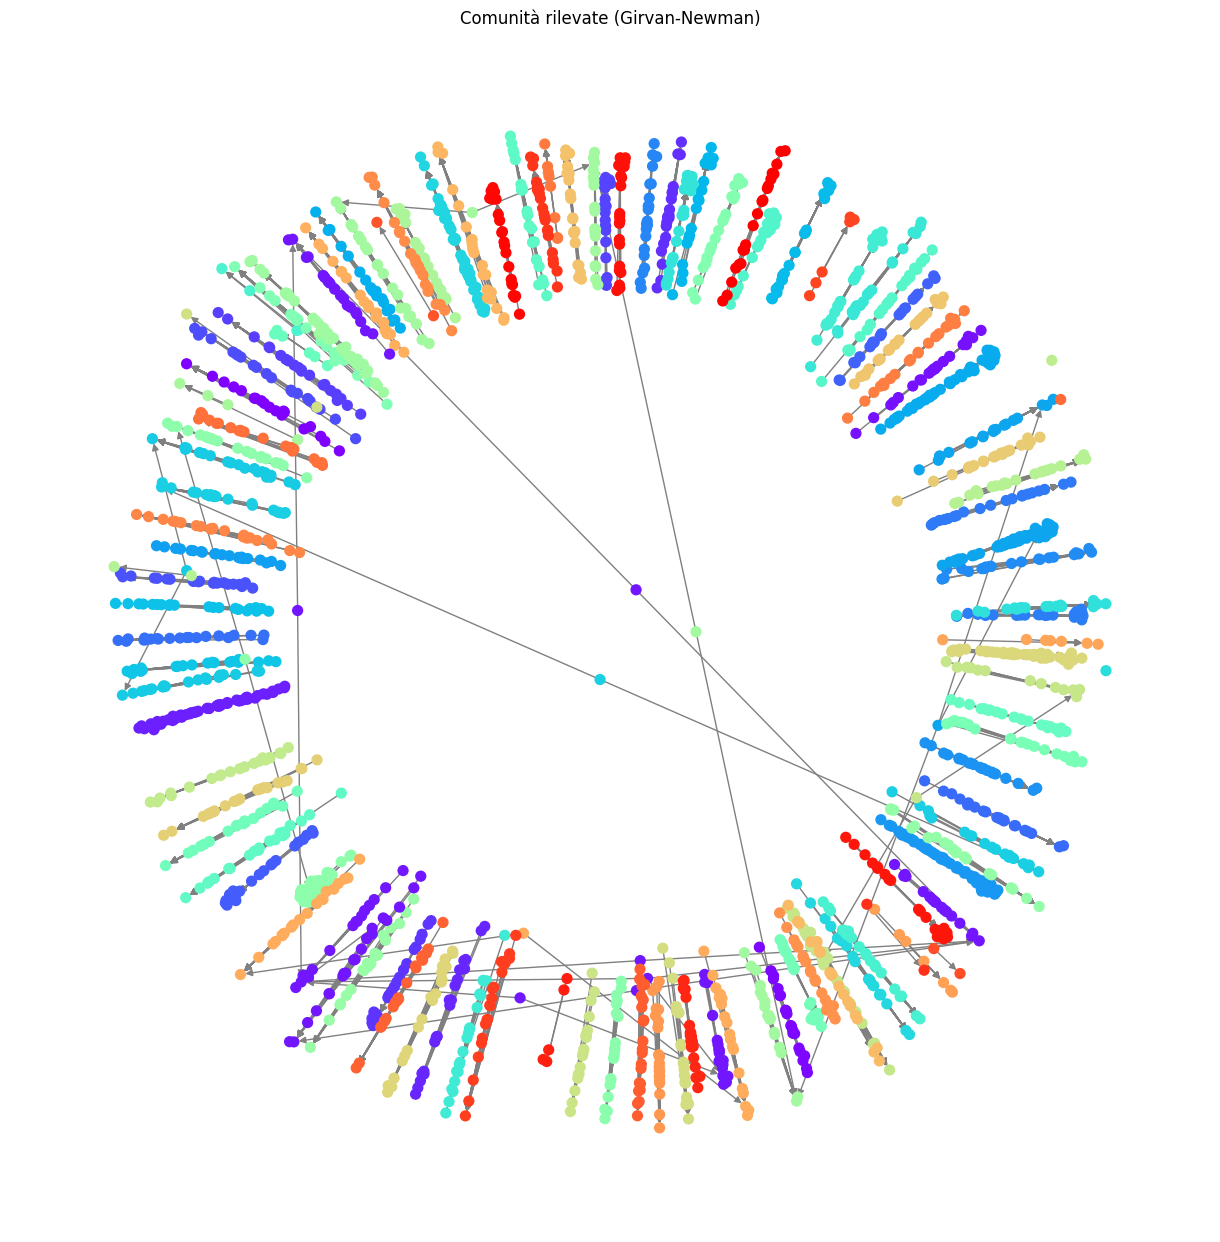

In [60]:
import matplotlib.pyplot as plt
import networkx as nx

# Associa un numero di comunità ai nodi (Girvan-Newman)
gn_community_map = {}
for i, community in enumerate(gn_communities):
    for node in community:
        gn_community_map[node] = i

# Aggiungi l'attributo 'community' ai nodi del grafo
nx.set_node_attributes(G, gn_community_map, 'community')

# Visualizza il grafo
pos = nx.spring_layout(G)  # Posizionamento dei nodi
node_colors = [G.nodes[node]['community'] for node in G.nodes()]

plt.figure(figsize=(12, 12))
nx.draw(
    G, pos,
    node_color=node_colors,
    cmap=plt.cm.rainbow,
    with_labels=False,
    node_size=50,
    edge_color='gray'
)
plt.title("Comunità rilevate (Girvan-Newman)")
plt.show()


In [ ]:
# Aggiungi l'attributo 'community' ai nodi
nx.set_node_attributes(G, louvain_communities_result, 'community')

# Visualizza il grafo
node_colors = [G.nodes[node]['community'] for node in G.nodes()]

plt.figure(figsize=(12, 12))
nx.draw(
    G, pos,
    node_color=node_colors,
    cmap=plt.cm.rainbow,
    with_labels=False,
    node_size=50,
    edge_color='gray'
)
plt.title("Comunità rilevate (Louvain)")
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
